In [289]:
suppressMessages(devtools::install_github("clairbarnes/rwwa"))
suppressMessages(library(rwwa))

varnm <- "tx5x"
rnm <- "kr"

In [289]:
rp <- switch(varnm, "hdwi" = 100, "tx5x" = 100, "pr-fm" = 5)

In [285]:
# specify arguments for all models
hdwi_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)
pr_args <- list(dist = "norm", type = "shift", varnm = "x", covnm = c("gmst"), lower = T)
tx_args <- list(dist = "gev", type = "shift", varnm = "x", covnm = c("gmst"), lower = F)

mdl_args <- switch(varnm, "hdwi" = hdwi_args, "pr-fm" = pr_args, "tx5x" = tx_args)

In [282]:
# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

# Trend in obs

In [286]:
rnm <- "kr"
gmst <- read.table("ts-kr/gmst.txt", col.names = c("year", "gmst"))

cov_2025 <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_pi <- cov_2025 - 1.3

for(fnm in list.files("ts-kr", pattern = paste0(varnm,".+ERA5land_",rnm), full.names = T)) {
    res_fnm <- gsub(".dat", "_gev.csv", gsub("ts-kr/korea-fires", "res-obs/res", fnm))
    
    if(!file.exists(res_fnm)) {
        varnm <- strsplit(strsplit(fnm, "_")[[1]][2], "-")[[1]][1]
        ts <- load_ts(fnm, col.names = c("year", "x"))
        df <- merge(gmst, ts)
                
        # get model parameters for selected model
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        boot_res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi)
        write.csv(boot_res, res_fnm)
    }
}

In [288]:
# compile results
obs_res <- t(sapply(list.files("res-obs", pattern = paste0(varnm,".+",rnm), full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
# rownames(obs_res) <- sapply(strsplit(rownames(obs_res), "_"), "[", 2)
rownames(obs_res) <- "ERA5land"
write.csv(obs_res, paste0("res-obs_",varnm,"_",rnm,".csv"))

# Trend in climate models

In [290]:
# highresmip & cmip6
nsamp <- 1000
for (fnm in list.files("ts-kr", pattern = paste0(varnm,".+",rnm), full.names = T)) {
    
    if(!(grepl("cmip6", fnm) | grepl("highres", fnm))) next
    
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    # will need to modify once FLOR / AM2.5 ensemble members are split out
    if (grepl("FLOR", fnm)) {gcm <- "FLOR"} 
        else if (grepl("AM2.5", fnm)) {gcm <- "AM2.5C360"} 
        else {gcm <- paste0(strsplit(fnm, "_")[[1]][4:5], collapse = "_")}
    print(gcm)
    
    # check if GMST time series exists
    if(grepl("cmip6", fnm)) {
        gmst_fnm <- list.files("ts-cmip6", pattern = paste0("SGSAT.+", gcm), full.names = T)
    } else if(grepl("highres", fnm)) {
        gmst_fnm <- list.files("ts-highresmip", pattern = paste0("GSAT.+", gcm), full.names = T)
    }
    
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    # pick up model to be fitted depending on variable
    mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
        
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-kr/", "mdl-eval-kr/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

[1] "ACCESS-CM2_r1i1p1f1"
[1] "ACCESS-ESM1-5_r1i1p1f1"
[1] "AWI-CM-1-1-MR_r1i1p1f1"
[1] "BCC-CSM2-MR_r1i1p1f1"
[1] "CAMS-CSM1-0_r2i1p1f1"
[1] "CanESM5_r10i1p1f1"
[1] "CanESM5_r1i1p1f1"
[1] "CMCC-ESM2_r1i1p1f1"
[1] "CNRM-CM6-1_r1i1p1f2"
[1] "CNRM-CM6-1-HR_r1i1p1f2"
[1] "CNRM-ESM2-1_r1i1p1f2"
[1] "EC-Earth3_r1i1p1f1"
[1] "EC-Earth3-CC_r1i1p1f1"
[1] "EC-Earth3-Veg_r1i1p1f1"
[1] "EC-Earth3-Veg-LR_r1i1p1f1"
[1] "FGOALS-g3_r1i1p1f1"
[1] "GFDL-CM4_r1i1p1f1"
[1] "GFDL-ESM4_r1i1p1f1"
[1] "HadGEM3-GC31-LL_r1i1p1f3"
[1] "HadGEM3-GC31-MM_r1i1p1f3"
[1] "INM-CM4-8_r1i1p1f1"
[1] "INM-CM5-0_r1i1p1f1"
[1] "IPSL-CM6A-LR_r1i1p1f1"
[1] "KACE-1-0-G_r1i1p1f1"
[1] "KIOST-ESM_r1i1p1f1"
[1] "MIROC-ES2L_r1i1p1f2"
[1] "MIROC6_r1i1p1f1"
[1] "MPI-ESM1-2-LR_r1i1p1f1"
[1] "MRI-ESM2-0_r1i1p1f1"
[1] "NESM3_r1i1p1f1"
[1] "NorESM2-LM_r1i1p1f1"
[1] "NorESM2-MM_r1i1p1f1"
[1] "TaiESM1_r1i1p1f1"
[1] "UKESM1-0-LL_r14i1p1f2"
[1] "UKESM1-0-LL_r1i1p1f2"


ERROR: Error in optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, : non-finite finite-difference value [4]


In [9]:
# compile results
res <- t(sapply(list.files("res-kr", pattern = paste0(varnm,".+",rnm), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm,"_")[[1]][3:5], collapse = "_"))
write.csv(res, paste0("res-models_",varnm,"_",rnm,".csv"))


## AM2.5 / FLOR

In [ ]:
# provisional values for initial trend check
for (fnm in list.files("ts-princeton", pattern = paste0(varnm,".+kr"), full.names = T)) {
    res_fnm <- gsub("ts", "res", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
    
    gcm <- paste0(strsplit(fnm, "_")[[1]][3:4], collapse = "_")

    # check that GMST time series exists
    gmst_fnm <- list.files("ts-princeton", pattern = paste0("gmst_", gcm), full.names = T)
    if(length(gmst_fnm) == 0) next
    

    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    
    mdl_args <- switch(varnm, "hdwi" = hdwi_args)
    mdl <- do.call(fit_ns, append(mdl_args, list("data" = df)))
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut, y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)
    
    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res-princeton/", "mdl-eval-kr/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

In [35]:
res <- t(sapply(list.files("res-princeton", pattern = paste0(varnm,".+kr"), full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm,"_")[[1]][3:4], collapse = "_"))
write.csv(res, paste0("res-princeton_",varnm,"_kr.csv"))

# Synthesis of initial results

In [246]:
varnm <- "hdwi"
stype <- "rel"
rnm <- "kr"

In [247]:
stitle <- paste0(switch(stype, "abs" = "Change in ", "rel" = "% change in "), toupper(varnm))

dI_xlim <- switch(paste0(varnm,stype), "hdwiabs" = c(-4,6), "hdwirel" = c(-25,50))
PR_xlim <- switch(varnm, "hdwi" = c(1e-3,1e5))

In [248]:
res_obs <- read.csv(paste0("res-obs_",varnm,"_",rnm,".csv"), row.names = "X")
res_models <- read.csv(list.files(pattern = paste0("res-models_",varnm,".+",rnm,".csv")), row.names = "X")
res_princeton <- read.csv(paste0("res-princeton_",varnm,"_kr.csv"), row.names = "X")

In [249]:
am25_dI_attr <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("AM2", rownames(res_princeton)), grepl(paste0("attr_dI.",stype), colnames(res_princeton))],
                          synth_type = stype)

am25_PR_attr <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("AM2", rownames(res_princeton)), grepl("attr_PR", colnames(res_princeton))],
                          synth_type = "PR")

am25_dI_proj <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("AM2", rownames(res_princeton)), grepl(paste0("proj_dI.",stype), colnames(res_princeton))],
                          synth_type = stype)

am25_PR_proj <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("AM2", rownames(res_princeton)), grepl("proj_PR", colnames(res_princeton))],
                          synth_type = "PR")

In [250]:
flor_dI_attr <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("FLOR", rownames(res_princeton)), grepl(paste0("attr_dI.",stype), colnames(res_princeton))],
                          synth_type = stype)

flor_PR_attr <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("FLOR", rownames(res_princeton)), grepl("attr_PR", colnames(res_princeton))],
                          synth_type = "PR")

flor_dI_proj <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("FLOR", rownames(res_princeton)), grepl(paste0("proj_dI.",stype), colnames(res_princeton))],
                          synth_type = stype)

flor_PR_proj <- synthesis(obs_in = NA,
                          models_in = res_princeton[grepl("FLOR", rownames(res_princeton)), grepl("proj_PR", colnames(res_princeton))],
                          synth_type = "PR")

In [251]:
write.csv(flor_dI_attr$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(flor_PR_attr$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(flor_dI_proj$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(flor_PR_proj$df, paste0("synth/synth-flor_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

write.csv(am25_dI_attr$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(am25_PR_attr$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(am25_dI_proj$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(am25_PR_proj$df, paste0("synth/synth-am25_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

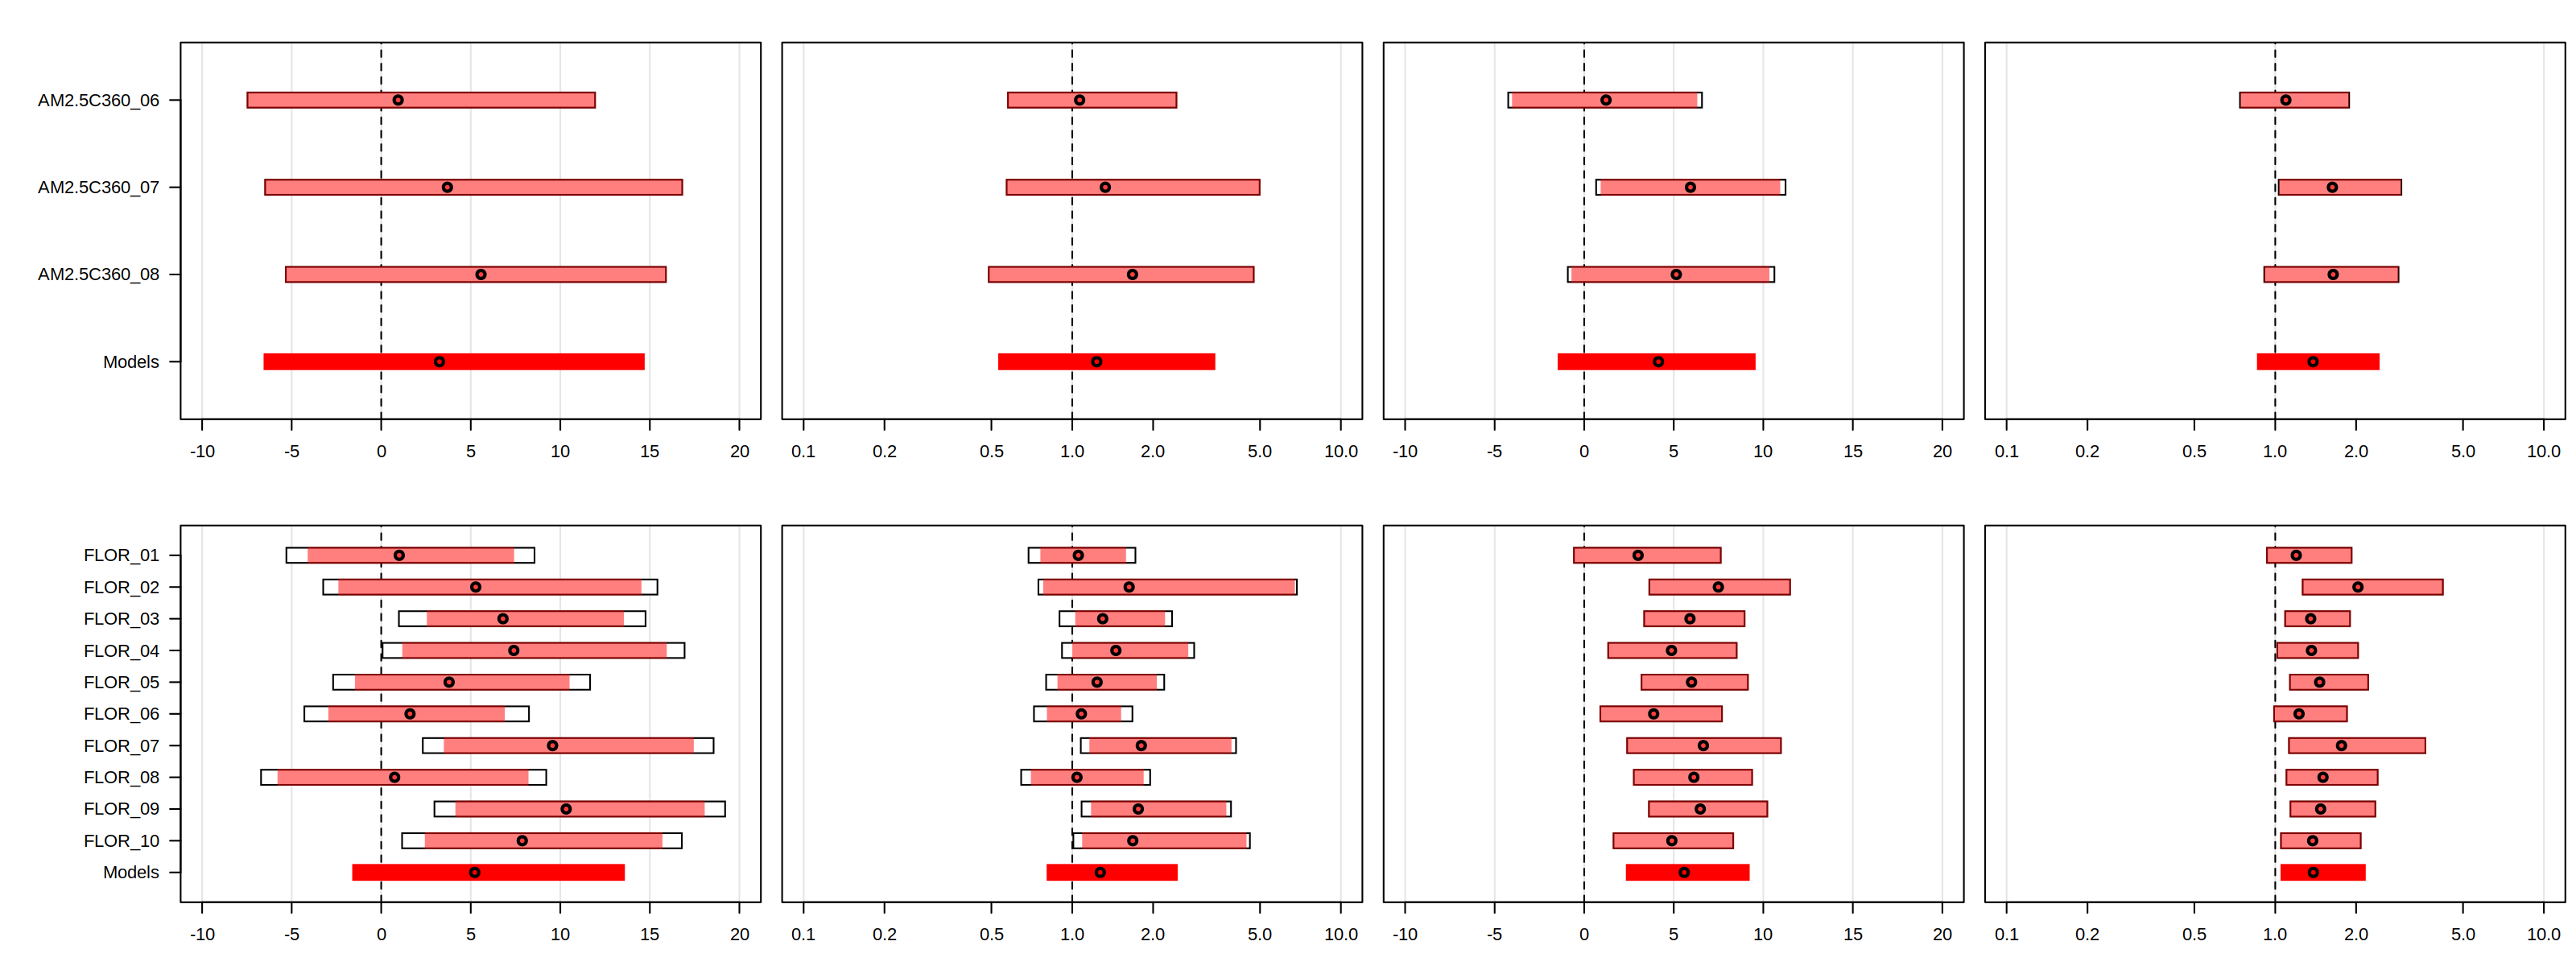

In [252]:
prep_window(c(2,4), h = 3, oma = c(0,8,0,0), mar = c(3,0.5,2,0.5))

dI_xlim <- switch(stype, "abs" = c(-2,3), "rel" = c(-10,20))

plot_synthesis(am25_dI_attr, xlim = dI_xlim)
plot_synthesis(am25_PR_attr, hide_labels = T, xlim = c(1e-1,1e1))
plot_synthesis(am25_dI_proj, hide_labels = T, xlim = dI_xlim)
plot_synthesis(am25_PR_proj, hide_labels = T, xlim = c(1e-1,1e1))

plot_synthesis(flor_dI_attr, xlim = dI_xlim)
plot_synthesis(flor_PR_attr, hide_labels = T, xlim = c(1e-1,1e1))
plot_synthesis(flor_dI_proj, hide_labels = T, xlim = dI_xlim)
plot_synthesis(flor_PR_proj, hide_labels = T, xlim = c(1e-1,1e1))

In [253]:
res_flor <- data.frame(c(setNames(flor_PR_attr$df[nrow(flor_PR_attr$df),3:5], paste0("attr_PR_",c("est", "lower", "upper"))),
                         setNames(flor_dI_attr$df[nrow(flor_dI_attr$df),3:5], paste0("attr_dI.",stype, "_",c("est", "lower", "upper"))),
                         setNames(flor_PR_proj$df[nrow(flor_PR_proj$df),3:5], paste0("proj_PR_",c("est", "lower", "upper"))),
                         setNames(flor_dI_proj$df[nrow(flor_dI_proj$df),3:5], paste0("proj_dI.",stype, "_",c("est", "lower", "upper")))), 
                       row.names = "FLOR (10)")

In [254]:
res_am25 <- data.frame(c(setNames(am25_PR_attr$df[nrow(am25_PR_attr$df),3:5], paste0("attr_PR_",c("est", "lower", "upper"))),
                         setNames(am25_dI_attr$df[nrow(am25_dI_attr$df),3:5], paste0("attr_dI.",stype, "_",c("est", "lower", "upper"))),
                         setNames(am25_PR_proj$df[nrow(am25_PR_proj$df),3:5], paste0("proj_PR_",c("est", "lower", "upper"))),
                         setNames(am25_dI_proj$df[nrow(am25_dI_proj$df),3:5], paste0("proj_dI.",stype, "_",c("est", "lower", "upper")))), 
                       row.names = "AM2.5C360 (3)")

In [255]:
res_allmodels <- rbind(res_models[,colnames(res_flor)], res_flor, res_am25)

In [256]:
synth_dI_attr <- synthesis(obs_in = res_obs[,grepl(stype, colnames(res_obs)),drop = F],
                           models_in = res_allmodels[,grepl(paste0("attr_dI.",stype), colnames(res_allmodels))],
                           synth_type = stype)

synth_PR_attr <- synthesis(obs_in = infer_infinite(res_obs[,grepl("PR", colnames(res_obs)),drop = F]),
                           models_in = infer_infinite(res_allmodels[,grepl("attr_PR", colnames(res_allmodels))]),
                           synth_type = "PR")

In [257]:
synth_dI_proj <- synthesis(obs_in = NA,
                           models_in = res_allmodels[,grepl(paste0("proj_dI.",stype), colnames(res_allmodels))],
                           synth_type = stype)

synth_PR_proj <- synthesis(obs_in = NA,
                           models_in = infer_infinite(res_allmodels[,grepl("proj_PR", colnames(res_allmodels))]),
                           synth_type = "PR")

In [258]:
write.csv(synth_dI_attr$df, paste0("synth/synth_",varnm,"_",rnm,"_dI-",stype,"_attr.csv"), row.names = F)
write.csv(synth_PR_attr$df, paste0("synth/synth_",varnm,"_",rnm,"_PR_attr.csv"), row.names = F)
write.csv(synth_dI_proj$df, paste0("synth/synth_",varnm,"_",rnm,"_dI-",stype,"_proj.csv"), row.names = F)
write.csv(synth_PR_proj$df, paste0("synth/synth_",varnm,"_",rnm,"_PR_proj.csv"), row.names = F)

In [259]:
png(paste0("fig/synth_",varnm,"_",rnm,"_attr-",stype,".png"), width = 3 * 240); {
    prep_window(c(1,2), h = 8, w = 5, oma = c(0,18,0,0), mar = c(3,0.5,2,0.5))

    plot_synthesis(synth_dI_attr, main = stitle, xlim = dI_xlim)
    plot_synthesis(synth_PR_attr, hide_labels = T, main = "Change in likelihood", xlim = PR_xlim)
}; dev.off()

png 
  2

In [260]:
png(paste0("fig/synth_",varnm,"_",rnm,"_proj-",stype,".png"), width = 3 * 240); {
    prep_window(c(1,2), h = 8, oma = c(0,18,0,0), mar = c(3,0.5,2,0.5))

    plot_synthesis(synth_dI_proj, main = stitle, add_space = F, xlim = dI_xlim)
    plot_synthesis(synth_PR_proj, hide_labels = T, main = "Change in likelihood", add_space = F, xlim = PR_xlim)
}; dev.off()

png 
  2